In [1]:
from torch.utils.data import Dataset
import torch
# make autoreload
from IPython import get_ipython
import numpy as np
ipython = get_ipython()
ipython.magic('load_ext autoreload')

class PolyDataset(Dataset):
    def __init__(self, degree: int, num_points: int, num_functions: int, num_samples: int = 1):
        self.degree = degree # max degree of each sampled polynomial
        self.num_points = num_points # nr of points to sample from each polynomial as the context length
        self.num_functions = num_functions # nr of plolynomials to use, these will be random at each new step
        # self.num_samples = num_samples # nr of samples to generate for each function
        self.x = torch.linspace(0, 1, num_points)

    def __len__(self):
        return self.num_functions * self.num_points

    def __getitem__(self, idx: int ):
        # for beginning since there is a ton of polynomials to sample from we will just sample a random one
        # need to make sure that numerical evals stay within range of of float32
        # sample random polynomial of degree k
        # sample random points from the polynomial

        # y = a_n * x^n + a_n-1 * x^n-1 + ... + a_0

        # sample k roots
        roots = torch.rand(self.degree) 

        # numpy get random polynomial
        y = self._polynomial(roots, self.x)
        return torch.tensor(y).reshape(-1)
    
    def _polynomial(self, roots, x):
        coeff = np.poly(roots)
        return np.polyval(coeff, x)


/tmp/ipykernel_163636/3791145972.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic('load_ext autoreload')


In [16]:
np.poly(torch.rand(10))

array([ 1.0000000e+00, -4.6548452e+00,  9.3037348e+00, -1.0479361e+01,
        7.3408518e+00, -3.3264210e+00,  9.7957343e-01, -1.8219131e-01,
        1.9774027e-02, -1.0259694e-03,  1.1602624e-05], dtype=float32)

In [8]:
torch.linspace(0, 1, 6)[None,:]

tensor([[0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000]])

In [9]:
from model.hippo import HiPPO_LegT

model = HiPPO_LegT(10,dt=0.1)

In [10]:
ds = PolyDataset(15, 10, 1)
dl = torch.utils.data.DataLoader(ds, batch_size=3, shuffle=True)

In [11]:
for i, y in enumerate(dl):
    model.forward_batched(y)
    break

torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([10, 10]) torch.Size([10]) torch.Size([10]) torch.Size([1])


RuntimeError: 1D tensors expected, but got 2D and 1D tensors

In [437]:
import torch
from icl_learning.data import PolyDataset, WhiteSignalDataset, get_datasets
from model.hippo import HiPPO_LegT
import yaml
import torch
from torch.utils.data import DataLoader
from icl_learning.optimizer import select_optim
import wandb
from matplotlib import pyplot as plt
from icl_learning.config import load_configs
import random
import numpy as np
from icl_learning.train import load_checkpoint

config = load_configs()
dataset = get_datasets(config=config, test=False)
dataset_test = get_datasets(config=config, test=True)
dataloader_test = DataLoader(dataset_test, batch_size=config["train"]["batch_size"], shuffle=False)
dataloader = DataLoader(dataset, batch_size=config["train"]["batch_size"], shuffle=False)

model = HiPPO_LegT(N=config["model"]["rank"], dt=1/config["train"]["data"]["num_points"], teacher_ratio=config["train"]["teacher_ratio"], trainable=True)
model_test = HiPPO_LegT(N=config["model"]["rank"], dt=1/config["train"]["data"]["num_points"], teacher_ratio=config["train"]["teacher_ratio"], trainable=False)

opt=select_optim(config, model)
load_checkpoint(config, model, opt=opt)

torch.Size([128, 128])

/Users/kilianhaefeli/In-Context-SSM/icl_learning/data.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y).to(torch.float32).to(self.device)


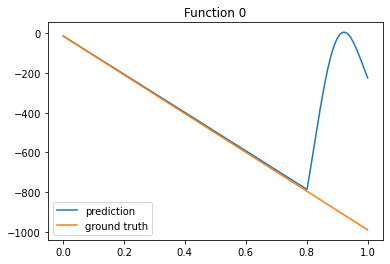

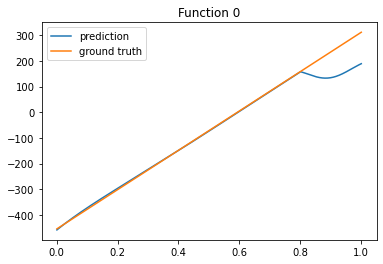

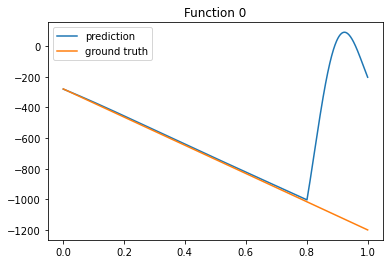

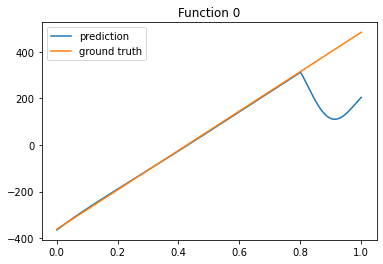

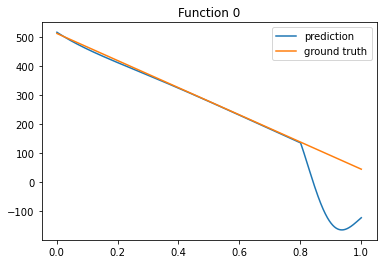

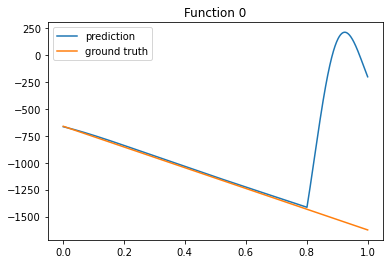

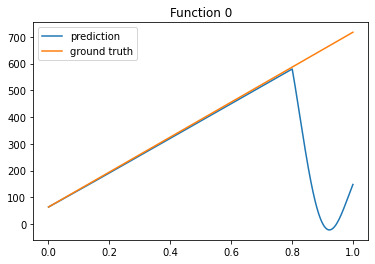

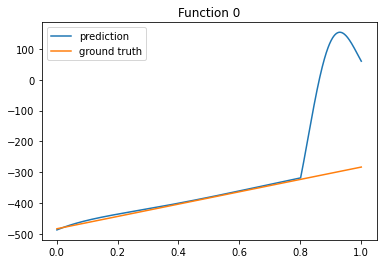

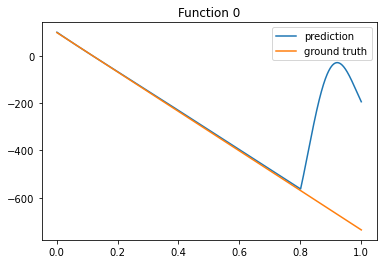

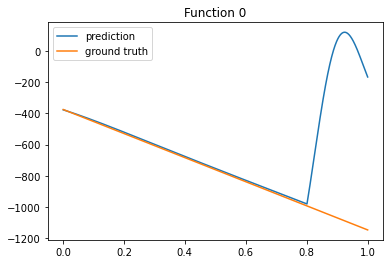

In [419]:

from icl_learning.train import autoregressive

@autoregressive
def test(config, dataloader, model, test=True, start=0, end = 1000):
    model.eval()
    x = dataloader.dataset.x
    with torch.no_grad():
        total_loss = 0
        for i, y in enumerate(dataloader):
            y_hat = model(y) # Now y is the signal 1,2,3,4,5,N+1, and y is 0,1,2,3,4,5..., N
            loss = torch.nn.MSELoss()(y_hat[:,:-1], y[:,1:])
            total_loss += loss.item()
            # make plots of the predictions and the ground truth and log them to wandb
            if i==0:
                for j in range(config["test"]["num_plots"]):
                    plt.figure()
                    plt.plot(x[start+1:end], y_hat[j][start:end-1].numpy(), label="prediction")
                    plt.plot(x[start+1:end], y[j][start+1:end].numpy(), label="ground truth")
                    plt.legend()
                    plt.title(f"Function {i}")
            else: 
                break

        # evaluate weight distane of D,C to the learned ones
        
        

    model.train()


test(config, dataloader, model, test=False)

In [8]:
import numpy as np
import torch
np.polynomial.legendre.Legendre([1,2,3,4,5,6,7,8,9,10])(torch.linspace(-1,1,10))

tensor([-5.0000, -1.4288,  1.7919, -0.5070, -0.2754,  2.2776, -1.5753,  1.6132,
        -0.3637, 55.0000])

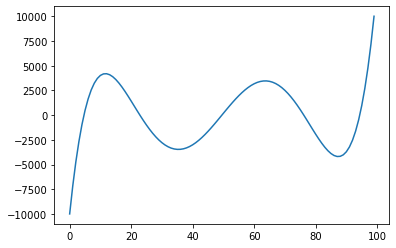

In [45]:
from matplotlib import pyplot as plt
plt.plot(np.polynomial.legendre.Legendre([1,1,5,0.1,0.2, 10000])(torch.linspace(-1,1,100)))

In [420]:
model

HiPPO_LegT()

In [49]:
import numpy
a=np.array([2,2])
b=np.array([[1,1,1],[1,1,1]])
numpy.dot(a, b, out=None)

array([4, 4, 4])

In [438]:
model.C_discr

Parameter containing:
tensor([ 0.2569, -1.2561,  0.4594,  0.6898,  0.6390,  1.1600,  0.9132,  0.5384,
         0.0091, -1.5817,  0.5089,  0.2869,  0.3508, -1.1975, -1.0018,  1.1324,
         0.0397,  0.7607,  0.1076,  0.1090,  1.0175, -0.4368,  0.1754, -0.3830,
        -0.3553, -0.2299,  0.3014, -0.3995,  1.3350, -0.8154, -0.1076, -0.3605,
         1.5262,  0.2758,  1.1111, -1.4063,  0.3463,  0.9689,  0.1615,  1.1447,
        -0.4380,  1.4886,  2.3781, -0.2836, -0.3663,  1.5326,  1.6588, -0.4436,
        -0.3409, -0.2025, -1.2652, -0.8394, -0.9249, -0.6886,  0.0446,  0.3135,
         1.6297, -0.9191,  1.0636, -0.1347,  0.0298,  0.7541, -1.0435,  0.4617,
         0.2457,  0.5717,  0.3684,  2.5345, -0.5585, -0.4518, -0.5439, -0.4762,
        -0.5581,  1.2683,  1.4997, -0.4915, -0.7531,  0.5507, -0.4730,  0.7122,
         0.2822, -1.4365,  1.6267,  1.8751, -0.5335, -0.3085,  0.3651,  0.4137,
         0.7378,  2.0894, -0.0977, -0.7191, -1.3001, -0.6517,  0.0461,  1.8738,
        -0.4384,  

In [436]:
model.C_discr

Parameter containing:
tensor([ 8.0167e-01, -7.1137e-01,  1.0042e+00,  1.2346e+00,  1.1838e+00,
         1.7048e+00,  1.4579e+00,  1.0832e+00,  5.5382e-01, -1.0370e+00,
         1.0536e+00,  8.3166e-01,  8.9556e-01, -6.5277e-01, -4.5708e-01,
         1.6771e+00,  5.8443e-01,  1.3055e+00,  6.5230e-01,  6.5374e-01,
         1.5623e+00,  1.0793e-01,  7.2010e-01,  1.6171e-01,  1.8949e-01,
         3.1481e-01,  8.4611e-01,  1.4523e-01,  1.8797e+00, -2.7063e-01,
         4.3711e-01,  1.8425e-01,  2.0710e+00,  8.2054e-01,  1.6558e+00,
        -8.6158e-01,  8.9103e-01,  1.5136e+00,  7.0627e-01,  1.6895e+00,
         1.0669e-01,  2.0333e+00,  2.9229e+00,  2.6114e-01,  1.7848e-01,
         2.0774e+00,  2.2036e+00,  1.0112e-01,  2.0379e-01,  3.4219e-01,
        -7.2047e-01, -2.9468e-01, -3.8016e-01, -1.4382e-01,  5.8929e-01,
         8.5819e-01,  2.1745e+00, -3.7438e-01,  1.6083e+00,  4.0999e-01,
         5.7451e-01,  1.2988e+00, -4.9875e-01,  1.0064e+00,  7.9043e-01,
         1.1164e+00,  9.1314e

In [435]:
model.D_discr

Parameter containing:
tensor([0.6240], requires_grad=True)

In [434]:
model_test.D_discr

tensor([-1.2781])

In [433]:
model_test.C_discr

tensor([1.1390, 1.9726, 2.5460, 3.0114, 3.4130, 3.7709, 4.0964, 4.3964, 4.6758,
        4.9377, 5.1847, 5.4186, 5.6410, 5.8529, 6.0553, 6.2490, 6.4347, 6.6128,
        6.7839, 6.9483, 7.1065, 7.2586, 7.4050, 7.5458, 7.6813, 7.8117, 7.9371,
        8.0576, 8.1734, 8.2846, 8.3912, 8.4935, 8.5914, 8.6850, 8.7744, 8.8596,
        8.9408, 9.0179, 9.0910, 9.1601, 9.2253, 9.2865, 9.3439, 9.3974, 9.4471,
        9.4930, 9.5350, 9.5733, 9.6078, 9.6386, 9.6656, 9.6889, 9.7084, 9.7242,
        9.7363, 9.7446, 9.7492, 9.7501, 9.7473, 9.7408, 9.7305, 9.7166, 9.6989,
        9.6774, 9.6522, 9.6233, 9.5907, 9.5543, 9.5141, 9.4702, 9.4225, 9.3711,
        9.3158, 9.2568, 9.1940, 9.1273, 9.0568, 8.9826, 8.9044, 8.8225, 8.7366,
        8.6469, 8.5534, 8.4559, 8.3546, 8.2493, 8.1401, 8.0270, 7.9100, 7.7890,
        7.6640, 7.5351, 7.4021, 7.2652, 7.1243, 6.9793, 6.8303, 6.6773, 6.5202,
        6.3590, 6.1938, 6.0244, 5.8510, 5.6734, 5.4917, 5.3058, 5.1158, 4.9216,
        4.7232, 4.5207, 4.3139, 4.1029, 

In [57]:
# find P s.t. PB = P, and that A=PAP-1 and that C' = PC

In [ ]:
# find P s.t. PB = P, and that A=PAP-1 and that ||C' - PC|| is minimized

In [432]:
C_discr = torch.tensor(model.C_discr.detach().numpy())
C_discr_test = torch.tensor(model_test.C_discr.detach().numpy())
A = torch.tensor(model.A)
B = torch.tensor(model.B)

#C_discr = torch.randn_like(C_discr)

C_discr.requires_grad = False
C_discr_test.requires_grad = False
A.requires_grad = False
B.requires_grad = False


/var/folders/x1/3x4xmsg90zl0_86zz3zvpt500000gn/T/ipykernel_57929/3332505059.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(model.A)
/var/folders/x1/3x4xmsg90zl0_86zz3zvpt500000gn/T/ipykernel_57929/3332505059.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(model.B)


In [412]:
PP = torch.randn(A.shape)
P = torch.clone(PP)
P = torch.nn.Parameter(P, requires_grad=True)
opt=torch.optim.SGD([P], lr=0.1)


In [413]:
for i in range(1000000):
    loss = torch.nn.MSELoss()(P @ A, A @ P)
    loss.backward()
    opt.step()
    P.grad.zero_()

In [404]:
P @ B - B

tensor([ 0.0012, -0.0023,  0.0005, -0.0026], grad_fn=<SubBackward0>)

In [392]:
torch.norm(C_discr - C_discr_test,2)

tensor(0.1149)

In [397]:
torch.norm(C_discr - P @ C_discr_test,2)

tensor(0.1306, grad_fn=<LinalgVectorNormBackward0>)

In [280]:
A @ P - P @ A

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 5x5)

In [236]:
A @ P 

tensor([[ 0.2796,  0.3162,  0.3498, -0.2202, -0.5102],
        [-0.7155,  0.3307,  0.2068,  0.2148,  0.5284],
        [ 0.8496, -0.4925, -0.3097, -0.0610, -0.0564],
        [ 0.3484,  0.2664,  0.0731,  0.6396, -0.3022],
        [-0.3399,  0.2064,  0.0514, -0.0095,  0.3051]], grad_fn=<MmBackward0>)

In [410]:
A

tensor([[ 0.9990,  0.0017, -0.0022,  0.0026],
        [-0.0017,  0.9970,  0.0039, -0.0046],
        [-0.0022, -0.0039,  0.9950,  0.0059],
        [-0.0026, -0.0046, -0.0059,  0.9930]])

In [400]:
model.D_discr

Parameter containing:
tensor([1.0077], requires_grad=True)

In [399]:
model_test.D_discr

tensor([1.0161])

In [367]:
model_test.D

tensor([16.])

In [346]:
(1-16384/2000) /(1+16384/2000)

-0.7824194952132288

In [347]:
(1-16384/2000) /(1+16384/2000)

-0.7824194952132288

In [348]:
(1+16384/2000) /(1-16384/2000)

-1.2780867630700778

In [402]:
model_test.C_discr

tensor([-0.0081, -0.0122, -0.0113, -0.0053])

In [370]:
model.D_discr

Parameter containing:
tensor([1.0124], requires_grad=True)

In [401]:
model.C_discr

Parameter containing:
tensor([-0.1194, -0.0159,  0.0047, -0.0285], requires_grad=True)

In [383]:
# u_t+1 = C x_t + D u_t
# u_t+1 = C B u_t + D u_t
model_test.C_discr

tensor([-0.0081, -0.0122, -0.0113, -0.0053])

In [382]:
model.B

tensor([0.0010, 0.0017, 0.0022, 0.0026])